In [2]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


DATE = '2020-09-03_EnvAlt'
EXP = 'exp3_n_ep1000_lr0.001'
LOAD_DIR = Path('../saved_data') / DATE / EXP

# load general data
config = torch.load(LOAD_DIR / 'config')
total_rewards = torch.load(LOAD_DIR / 'tot_r')
times = torch.load(LOAD_DIR / 'running_times')

# load state data
versions = ['optim1', 'optim100']
states = dict()
plots = []
fig_count = 0
for version in versions:
    states.update({version: torch.load(LOAD_DIR / ('batch_states_' + version))})

FileNotFoundError: [Errno 2] No such file or directory: '..\\saved_data\\2020-09-03_EnvAlt\\exp3_n_ep1000_lr0.001\\config'

In [21]:
config


{'agents': ['FSC', 'Shell', 'Gov'],
 'active_agents': ['FSC', 'Shell'],
 'init_support': [inf, 0.0, 0.0],
 'init_resource': {'Shell': [0.025, 0.95, 0.025], 'Gov': [0.5, 0.5]},
 'delta_resource': 0.005,
 'delta_research': 0.05,
 'base_impacts': {'Shell': [0.38, 0.11], 'Gov': [0.03, 0.33]},
 'beta': 0.1,
 'reward_function': 'fsc_V2.2_eps4_0.05_shell_V2.1',
 'length_ep': 78,
 'n_ep': 1000,
 'lr': 0.001,
 'batch_size': 10,
 'gamma': 0.99,
 'save_interval': 5}

<h2><center>plots for total reward </center></h2>

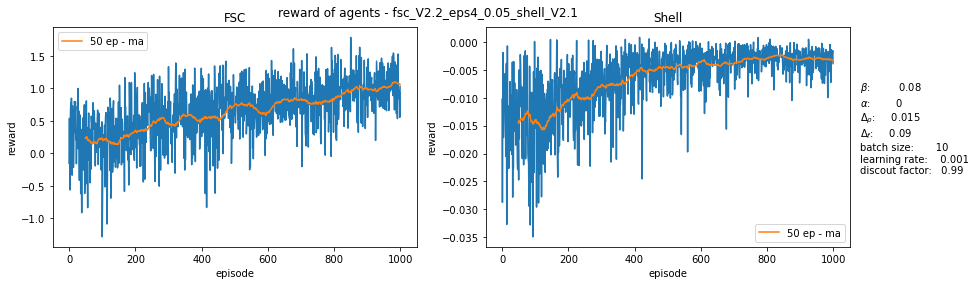

In [2]:
#plot total rewards of active agents and the rolling mean
window_width = 50

fig = plt.figure(fig_count, figsize=(12, 4))
plots.append(fig)
ax = [fig.add_subplot(121), fig.add_subplot(122)]
fig_count += 1

for i, agt in enumerate(config['active_agents']):
    ma = pd.Series(total_rewards[agt]).rolling(window_width).mean()
    ax[i].plot(total_rewards[agt])
    ax[i].plot(ma, label='{} ep - ma'.format(window_width))
    ax[i].set_title(agt)
    ax[i].set_xlabel('episode')
    ax[i].set_ylabel('reward')
    ax[i].legend()
fig.suptitle('reward of agents - ' + config['reward_function'])
fig.tight_layout()
fig.text(1, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                 r'$\alpha$:' + '\t {}'.format(config['alpha']) + '\n' +
                 r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                 r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                  'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                  'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                  'discout factor:' + '   {}'.format(config['gamma']));

<h2><center>network analysis</center></h2>

In [5]:
# determine dead neurons by calculation of difference of weights
agents = [torch.load(LOAD_DIR / 'agents_init'), torch.load(LOAD_DIR / 'agents_optim1_ep10')]
weights_diff = []
weights_diff.append(agents[0]['FSC'].get_networks()['All'][0].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['All'][0].weight.detach().numpy())
weights_diff.append(agents[0]['FSC'].get_networks()['All'][2].weight.detach().numpy() - \
                   agents[1]['FSC'].get_networks()['All'][2].weight.detach().numpy())
for i in weights_diff:
    print(np.where(np.all(np.isclose(i, 0), axis=1)))
    print(i)

(array([ 0,  1,  6, 14], dtype=int64),)
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-9.9986792e-04  9.9983811e-04 -9.9951029e-04 -9.9931099e-04]
 [ 9.9989772e-04  9.9915266e-04  9.9956989e-04 -9.8574162e-04]
 [ 9.9986419e-04  9.9977851e-04  9.9918246e-04 -9.9877268e-04]
 [-9.9975616e-04 -9.9984044e-04 -9.9730492e-04  9.9921227e-04]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-9.9970773e-04 -9.9977851e-04 -9.9730492e-04  9.9885464e-04]
 [ 9.9948049e-04  9.9936128e-04  9.9660456e-04 -9.9673122e-04]
 [-8.0868602e-04 -9.8553300e-04 -9.4860792e-05 -8.2105398e-06]
 [ 9.9876523e-04  9.8907948e-04  9.9375844e-04 -9.6157193e-04]
 [ 9.9167228e-04  9.9933147e-04 -9.9000335e-04 -9.9685788e-04]
 [ 9.9989772e-04  9.9948049e-04  9.9954009e-04 -9.9617243e-04]
 [ 9.9970400e-04 -9.9979341e-04  9.9909306e-04  9.9903345e-04]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-9.9983811e-0

<h2><center>plots for support</center></h2>

In [1]:
# loop over all versions
for version in versions:
    fig = plt.figure(fig_count, figsize=(12, 4))
    plots.append(fig)
    fig_count += 1
    # create two axes
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    # loop over each agent
    for key in ['Shell', 'Gov']:#config['agents']:#
        # calculate mean and std for support
        mean = states[version][key].mean(axis=0)[:, 0]
        std = states[version][key].std(axis=0)[:, 0]
        x = range(0, states[version][key].shape[1])
        # plot mean
        ax[0].plot(mean, label=key)
        ax[1].plot(mean, label=key)
        # plot std as an area
        ax[0].fill_between(x, mean+std, mean-std, alpha=0.2)
        # plot max and min as an area
        ax[1].fill_between(x, states[version][key].max(axis=0)[:, 0],
                           states[version][key].min(axis=0)[:, 0], alpha=0.2)
    # set some plot properties
    fig.suptitle('support of agents of batch - ' + version)
#     fig.text(0.93, 0.4, r'$\beta_{FSC}$:' + '\t {}'.format(config['support_factor']) + '\n' +
#                         r'$\beta_{j}$:' + ' \t  {}'.format(config['support_factor'] * config['ratio of support factor']) + '\n' +
#                         r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
#                          'sub lvl:' + '   {}'.format(config['sub_lvl'])  + '\n\n' +
#                          'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
#                          'learning rate:' + '    {}'.format(config['lr']) + '\n' +
#                          'discout factor:' + '   {}'.format(config['gamma']))
    ax[0].set_title('mean and standard deviation')
    ax[1].set_title('mean and max-min')
    for axis in fig.get_axes():
#         axis.set_ylim(ymax=0.3)
        axis.set_xlabel('step')
        axis.set_ylabel('level of support')
        axis.legend()

NameError: name 'versions' is not defined

<h2><center>plots for resource assignment</center></h2>

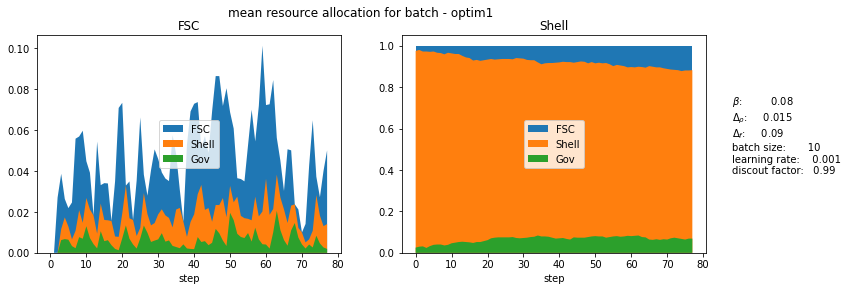

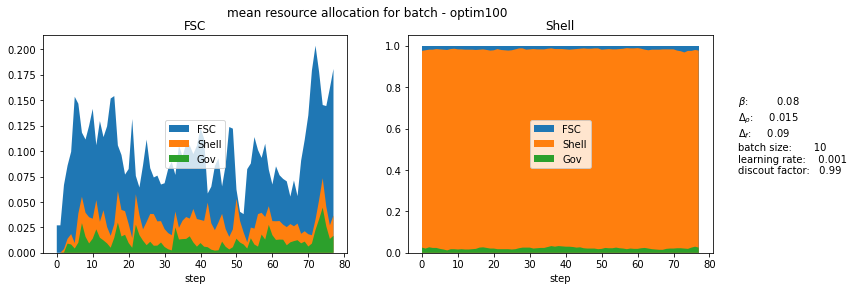

In [7]:
for version in versions:
    fig = plt.figure(fig_count, figsize=(12, 4))
    plots.append(fig)
    # create new axes
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    fig_count += 1

    for i, key in enumerate(config['active_agents']):
        # calculate mean of resource assignment to the different partner agents
        x = range(0, states[version][key].shape[1])
        fsc = states[version][key].mean(axis=0)[:, 1]
        shell = states[version][key].mean(axis=0)[:, 2]
        gov = states[version][key].mean(axis=0)[:, 3]

        # create stacked plots
        ax[i].stackplot(x, gov + shell + fsc)
        ax[i].stackplot(x, gov + shell)
        ax[i].stackplot(x, gov)
        ax[i].set_title(key)
        ax[i].set_xlabel('step')
        ax[i].legend(['FSC', 'Shell', 'Gov'], loc='center')
    fig.suptitle('mean resource allocation for batch - ' + version)
    fig.text(0.93, 0.4, r'$\beta$:' + '\t {}'.format(config['beta']) + '\n' +
                    r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                    r'$\Delta_{f}$:' + '     {}'.format(config['delta_research'])  + '\n' +
                     'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                     'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                     'discout factor:' + '   {}'.format(config['gamma']));

<h2><center>plots for support calculation</center></h2>

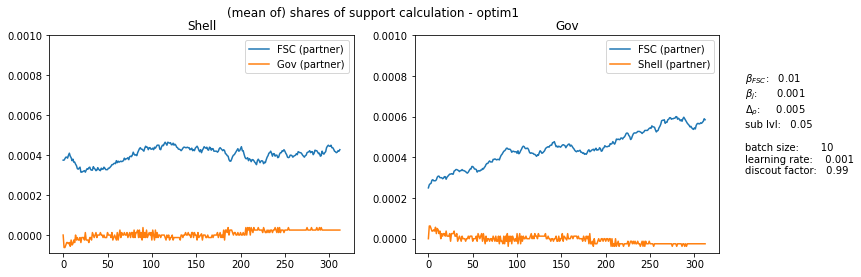

In [4]:
# %matplotlib notebook
# %matplotlib inline
support_calc = dict()
par_agt = {'Shell': ['FSC', 'Gov'], 'Gov': ['FSC', 'Shell']}
for version in versions:
    # load data
    support_calc.update({version: torch.load(LOAD_DIR / ('support_calc_' + version))})
    # create figure and axis
    fig = plt.figure(fig_count, figsize=(12, 4))    
    plots.append(fig)  
    fig_count += 1
    ax = [fig.add_subplot(121), fig.add_subplot(122)]
    
    for i, key in enumerate(support_calc[version].keys()):
        x = range(0, support_calc[version][key].shape[1])
        mean = support_calc[version][key].mean(axis=0)[:, :]               
#         ax[i].plot(mean[:,0], label='support before' ) # oder raus
        ax[i].plot(mean[:,1], label= par_agt[key][0] + ' (partner)')
        ax[i].plot(mean[:,2], label= par_agt[key][1] + ' (partner)')
        ax[i].legend()
        ax[i].set_title(key)
        ax[i].set_ylim(ymax=0.001)
    fig.suptitle('(mean of) shares of support calculation - ' + version)
    fig.text(0.93, 0.4, r'$\beta_{FSC}$:' + '\t {}'.format(config['support_factor']) + '\n' +
                        r'$\beta_{j}$:' + ' \t  {}'.format(config['support_factor'] * config['ratio of support factor']) + '\n' +
                        r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                         'sub lvl:' + '   {}'.format(config['sub_lvl'])  + '\n\n' +
                         'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                         'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                         'discout factor:' + '   {}'.format(config['gamma']))                
    

In [ ]:
# support von Gov ist genau das gespiegelte von Shell
support_calc[version]['Gov'].mean(axis=0)[:,:][:,2] + support_calc[version]['Shell'].mean(axis=0)[:,:][:,2]

<h2><center>plots for shell reward calculation</center></h2>

In [ ]:
reward_shell = dict()
for version in versions:
    # load data
    reward_shell.update({version: torch.load(LOAD_DIR / ('reward_shell_calc_' + version))})
    fig = plt.figure(fig_count)
    fig_count += 1
    ax = fig.add_subplot(111)
    
    mean = reward_shell[version].mean(axis=0)[:, :]
    x = range(0, reward_shell[version].shape[1])
    
    # create stacked plots
    ax.stackplot(x, mean[:, 3] + mean[:, 2] + mean[:, 1])
    ax.stackplot(x, mean[:, 3] + mean[:, 2])
    ax.stackplot(x, mean[:, 3])
    
    # axis properties
    ax.legend(['own return', 'external spending', 'internal spending'])
    ax.set_title('mean of shares of discounted reward for Shell - ' + version)
    fig.text(0.93, 0.4, r'$\beta_{FSC}$:' + '\t {}'.format(config['support_factor']) + '\n' +
                    r'$\beta_{j}$:' + ' \t  {}'.format(config['support_factor'] * config['ratio of support factor']) + '\n' +
                    r'$\Delta_{\rho}$:' + '     {}'.format(config['delta_resource'])  + '\n' +
                     'sub lvl:' + '   {}'.format(config['sub_lvl'])  + '\n\n' +
                     'batch size:' + '       {}'.format(config['batch_size']) + '\n' +
                     'learning rate:' + '    {}'.format(config['lr']) + '\n' +
                     'discout factor:' + '   {}'.format(config['gamma']))

<h2><center>saving plots to pdf or svg</center></h2>

In [5]:
plots

[<Figure size 864x288 with 2 Axes>]

In [12]:
plots[0].savefig((LOAD_DIR / (DATE + '_' + EXP + '_' + '_rewards' + '.pdf')), bbox_inches="tight")

In [ ]:
for i, version in enumerate(versions):
    plots[1+i].savefig((LOAD_DIR / (DATE + '_' + EXP + '_'  + versions[i] + '_support' + '.pdf')), bbox_inches="tight") # svg auch möglich

In [ ]:
plots[1]

<h2><center>load classes to load agents with pickle/torch</center></h2>

In [11]:
import copy
import torch
import numpy as np
from torch import nn

np.random.seed(42)


class Agent(object):
    def __init__(self, act_space, n_state, device):
        self.__state = None
        self.__n_neurons = 16
        self.__action_space = act_space
        self._device = device

        # Define network
        self.__base_network = nn.Sequential(nn.Linear(n_state, self.__n_neurons),
                                            nn.ReLU(),
                                            nn.Linear(self.__n_neurons, len(act_space)),
                                            nn.Softmax(dim=-1))

    def get_actions(self, state) -> dict:
        raise NotImplementedError

    def get_base_net(self):
        return self.__base_network

    def get_action_space(self):
        return self.__action_space


class Shell(Agent):
    def __init__(self, action_space, n_state, act_partners, device):
        super().__init__(action_space, n_state, device)
        self.__networks = dict()

        # initialize all necessary networks by copying the base network and send it to device
        for agt in act_partners:
            self.__networks.update({agt: copy.copy(super().get_base_net()).to(device)})

    def get_actions(self, state) -> dict:
        nets = self.__networks
        actions = dict()

        # derive an action for each network (i.e., policy)
        for key in nets.keys():
            # detach() should not be a problem hear, as for optimization predict() is called again,
            # where no detach() is used
            action_probs = self.predict(state, key).cpu().detach().numpy()
            actions.update({key: np.random.choice(super().get_action_space(), p=action_probs)})
        return actions

    def predict(self, state, partner_agt):
        # get the action probabilities as a tensor
        action_probs = self.__networks[partner_agt](torch.FloatTensor(state).to(self._device))
        return action_probs

    def get_networks(self):
        return self.__networks


class FSC(Agent):
    def __init__(self, action_space, n_state, act_partners, device):
        super().__init__(action_space, n_state, device)
        self.__networks = dict()
        self.__action_space = action_space

        # initialize all necessary networks by copying the base network and send it to device
        for agt in act_partners:
            self.__networks.update({agt: copy.copy(super().get_base_net()).to(device)})

    def get_actions(self, state) -> dict:
        nets = self.__networks
        actions = dict()

        # derive an action for each network (i.e., policy)
        for key in nets.keys():
            action_probs = self.predict(state, key).cpu().detach().numpy()
            actions.update({key: np.random.choice(super().get_action_space(), p=action_probs)})
        return actions

    def predict(self, state, partner_agt):
        # get the action probabilities as a tensor
        action_probs = self.__networks[partner_agt](torch.FloatTensor(state).to(self._device))
        return action_probs

    def get_networks(self):
        return self.__networks


class Gov(Agent):
    def __init__(self, action_space, n_state, activ_con, device):
        # super().__init__(action_space, n_state)
        pass

    def get_actions(self, state) -> dict:
        # government is performing maintain as action. That equals an passiv agent.
        return {'Shell': 0, 'FSC': 0}

